In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [4]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th
def model(x,a,b):
    return a*x**b

In [5]:
jobids = []
params = []
data = []
data_nn = []
folders = [datapath/"xx/h = 12", datapath/"alpha = 3", 
datapath/"h = 24/OBC/xx",datapath/"h = 24/PBC/xx",
datapath/"N = 11/OBC/xx",datapath/"N = 11/PBC/xx",
datapath/"N = 15/OBC/xx",datapath/"N = 15/PBC/xx",
datapath/"OBC_center/xx", 
datapath/"OBC_offcenter/xx"]
files = ["combined_file_{}.jld2".format(h) for h in ["h12", "α3",
"h24_OBC_xx","h24_PBC_xx",
"N11_OBC_xx","N11_PBC_xx",
"N15_OBC_xx","N15_PBC_xx",
"OBC_c_xx",
"OBC_nc_xx"]]
for (i,file) in enumerate(files):
    with h5py.File(folders[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])


folders_nn = [datapath/"xx_nn/h = 12",
datapath/"h = 24/OBC/xx_nn",datapath/"h = 24/PBC/xx_nn",
datapath/"N = 11/OBC/xx_nn",datapath/"N = 11/PBC/xx_nn",
datapath/"N = 15/OBC/xx_nn",datapath/"N = 15/PBC/xx_nn",
datapath/"OBC_center/xx_nn",
datapath/"OBC_offcenter/xx_nn"]
files_nn = ["combined_file_{}.jld2".format(h) for h in ["h12",
"h24_OBC_xx_nn","h24_PBC_xx_nn",
"N11_OBC_xx_nn","N11_PBC_xx_nn",
"N15_OBC_xx_nn","N15_PBC_xx_nn",
"OBC_c_xx_nn",
"OBC_nc_xx_nn"]]
for (i,file) in enumerate(files_nn):
    with h5py.File(folders_nn[i]/file,"r") as f:
        jobids.append(list(map(lambda s: s.decode("UTF-8"),f["jobid"][()])))
        data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
        params.append([f[f["params"][l]][()] for l in range(len(f["params"]))])

for  i in range(0,len(files)):
    data[i] = np.concatenate(data[i],axis=0)
    data[i] = rearrange_data(data[i])
for  i in range(0,len(files_nn)):
    data_nn[i] = np.concatenate(data_nn[i],axis=0)
    data_nn[i] = rearrange_data(data_nn[i])

/tmp/ipykernel_79162/3450343525.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))
/tmp/ipykernel_79162/3450343525.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_nn.append(2-2*np.array([f[f["data"][l]][()] for l in range(len(f["data"]))]))


## Indices:
0 h = 12 PBC \
1 alpha = 3 \
2 h = 24 OBC \
3 h = 24 PBC \
4 N = 11 OBC \
5 N = 11 PBC \
6 N = 15 OBC \
7 N = 15 PBC \
8 OBC center N = 13 \
9 OBC non-center N = 13

## Indices NN:
0 h = 12 PBC \
1 h = 24 OBC \
2 h = 24 PBC \
3 N = 11 OBC \
4 N = 11 PBC \
5 N = 15 OBC \
6 N = 15 PBC \
7 OBC center N = 13 \
8 OBC non-center N = 13 




In [6]:
for i in range(len(files)):
    print(files[i], data[i].shape[2],"\n")
for i in range(len(files_nn)):
    print(files_nn[i],data_nn[i].shape[2],"\n")

combined_file_h12.jld2 500 

combined_file_α3.jld2 500 

combined_file_h24_OBC_xx.jld2 500 

combined_file_h24_PBC_xx.jld2 500 

combined_file_N11_OBC_xx.jld2 500 

combined_file_N11_PBC_xx.jld2 500 

combined_file_N15_OBC_xx.jld2 50 

combined_file_N15_PBC_xx.jld2 50 

combined_file_OBC_c_xx.jld2 500 

combined_file_OBC_nc_xx.jld2 500 

combined_file_h12.jld2 500 

combined_file_h24_OBC_xx_nn.jld2 500 

combined_file_h24_PBC_xx_nn.jld2 500 

combined_file_N11_OBC_xx_nn.jld2 500 

combined_file_N11_PBC_xx_nn.jld2 500 

combined_file_N15_OBC_xx_nn.jld2 50 

combined_file_N15_PBC_xx_nn.jld2 50 

combined_file_OBC_c_xx_nn.jld2 500 

combined_file_OBC_nc_xx_nn.jld2 500 



In [7]:
N = 13
T = 10 ** np.linspace(-3,6,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [8]:
len(files_nn)

9

In [9]:
res = [disorder_mean(data[i]) for i in range(len(files))]
res_sem = [disorder_sem(data[i]) for i in range(len(files))]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

res_nn = [disorder_mean(data_nn[i]) for i in range(len(files_nn))]
res_sem_nn = [disorder_sem(data_nn[i]) for i in range(len(files_nn))]
red_nn = list(map(symmetrize,res_nn))
red_sem_nn = list(map(symmetrize,res_sem_nn))

# h = 12 α = 6 PBC

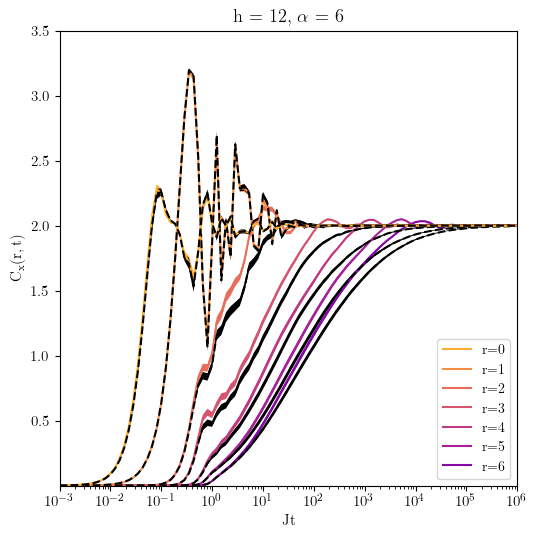

In [23]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[0][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[0][:,j],ls="dashed",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[0][:,j]-red_sem[0][:,j], red[0][:,j]+red_sem[0][:,j])
    ax.fill_between(T, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j],fc="black")



handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# h = 24 α = 6 PBC

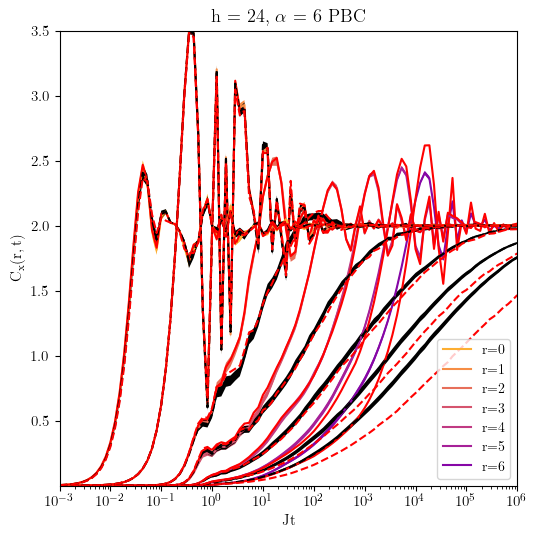

In [24]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[3][:,j],label="r={}".format(rvals[j])) #PBC
    ax.plot(T,red[2][:,j],c="red") #OBC
    ax.plot(T,red_nn[2][:,j],ls="dashed",c="black") #PBC
    ax.plot(T,red_nn[1][:,j],ls="dashed",c="red") #OBC

    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[3][:,j]-red_sem[3][:,j], red[3][:,j]+red_sem[3][:,j])
    ax.fill_between(T, red_nn[2][:,j]-red_sem_nn[2][:,j], red_nn[2][:,j]+red_sem_nn[2][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 PBC".format(24))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

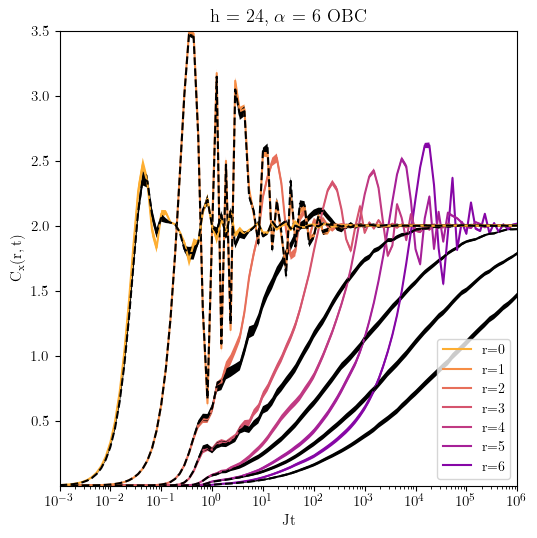

In [25]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[2][:,j],label="r={}".format(rvals[j])) #OBC
    ax.plot(T,red_nn[1][:,j],ls="dashed",c="black") #OBC
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[2][:,j]-red_sem[2][:,j], red[2][:,j]+red_sem[2][:,j])
    ax.fill_between(T, red_nn[1][:,j]-red_sem_nn[1][:,j], red_nn[1][:,j]+red_sem_nn[1][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 OBC".format(24))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# N = 11

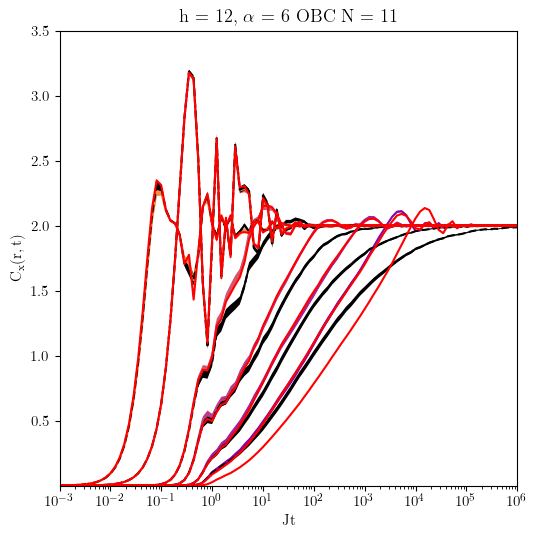

In [26]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,11//2+1):
    ax.plot(T,red[4][:,j],label="r={}".format(rvals[j])) #OBC
    ax.plot(T,red_nn[3][:,j],ls="dashed",c="black") #OBC
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[4][:,j]-red_sem[4][:,j], red[4][:,j]+red_sem[4][:,j])
    ax.fill_between(T, red_nn[3][:,j]-red_sem_nn[3][:,j], red_nn[3][:,j]+red_sem_nn[3][:,j],fc="black")


for j in range(0,N//2+1):
    ax.plot(T,red[8][:,j],c="red") #OBC
    #ax.plot(T,red_nn[0][:,j],ls="dashed",c="red") #OBC

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,11//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 OBC N = 11".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

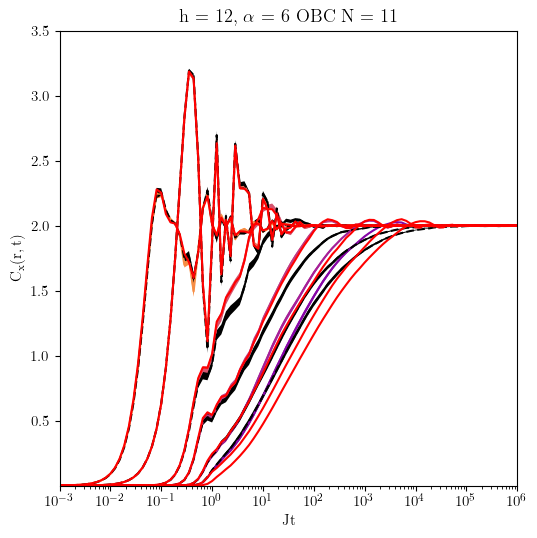

In [27]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,11//2+1):
    ax.plot(T,red[5][:,j],label="r={}".format(rvals[j])) #PBC
    ax.plot(T,red_nn[4][:,j],ls="dashed",c="black") #PBC
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[5][:,j]-red_sem[5][:,j], red[5][:,j]+red_sem[5][:,j])
    ax.fill_between(T, red_nn[4][:,j]-red_sem_nn[4][:,j], red_nn[4][:,j]+red_sem_nn[4][:,j],fc="black")


for j in range(0,N//2+1):
    ax.plot(T,red[0][:,j],c="red") #PBC
    #ax.plot(T,red_nn[0][:,j],ls="dashed",c="red") #PBC

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,11//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 OBC N = 11".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# N = 15

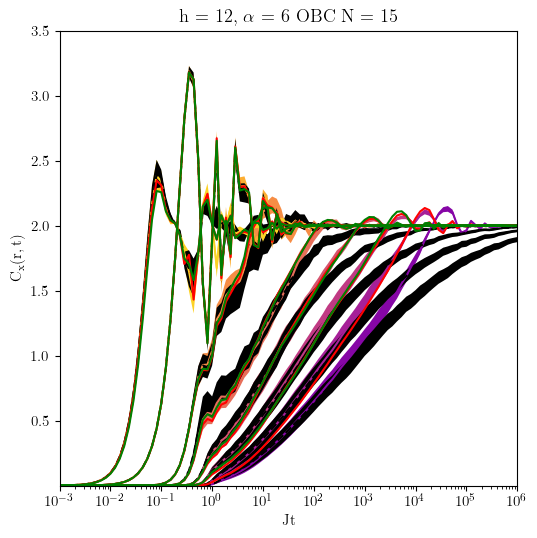

In [28]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,15//2+1):
    ax.plot(T,red[6][:,j],label="r={}".format(rvals[j])) #OBC
    ax.plot(T,red_nn[5][:,j],ls="dashed",c="black") #OBC

    ax.fill_between(T, red[6][:,j]-red_sem[6][:,j], red[6][:,j]+red_sem[6][:,j])
    ax.fill_between(T, red_nn[5][:,j]-red_sem_nn[5][:,j], red_nn[5][:,j]+red_sem_nn[5][:,j],fc="black")


for j in range(0,N//2+1):
    ax.plot(T,red[8][:,j],c="red") #OBC
    #ax.plot(T,red_nn[6][:,j],ls="dashed",c="red") #OBC

for j in range(0,11//2+1):
    ax.plot(T,red[4][:,j],c="green") #OBC
    #ax.plot(T,red_nn[0][:,j],ls="dashed",c="red") #OBC

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,11//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 OBC N = 15".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

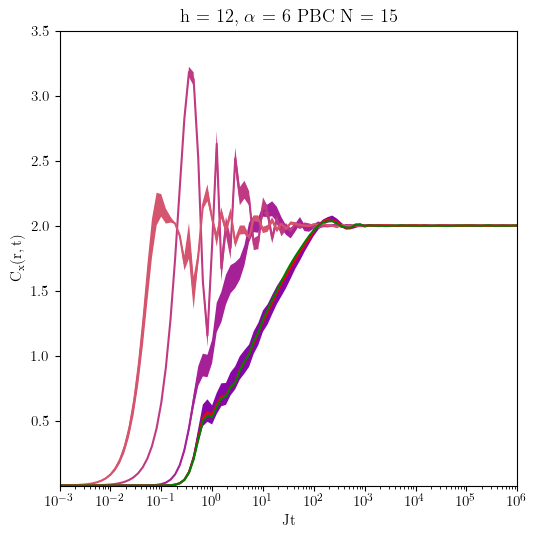

In [29]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,15//2+1):
    if j >= 4:
        ax.plot(T,red[7][:,j],label="r={}".format(rvals[j])) #PBC
        #ax.plot(T,red_nn[6][:,j],ls="dashed",c="black") #PBC

        ax.fill_between(T, red[7][:,j]-red_sem[7][:,j], red[7][:,j]+red_sem[7][:,j])
        #ax.fill_between(T, red_nn[6][:,j]-red_sem_nn[6][:,j], red_nn[6][:,j]+red_sem_nn[6][:,j],fc="black")


for j in range(0,N//2+1):
    if j == 3:
        ax.plot(T,red[0][:,j],c="red") #PBC
    #ax.plot(T,red_nn[0][:,j],ls="dashed",c="red") #PBC

for j in range(0,11//2+1):
    if j== 2:
        ax.plot(T,red[5][:,j],c="green") #PBC
    #ax.plot(T,red_nn[3][:,j],ls="dashed",c="red") #PBC

handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,11//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 6 PBC N = 15".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# α = 3

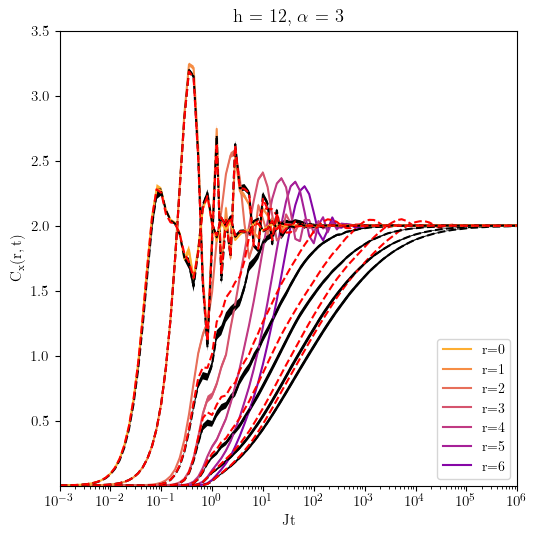

In [56]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[1][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[0][:,j],ls="dashed",c="black")
    ax.plot(T,red[0][:,j],ls="dashed",c="red")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[1][:,j]-red_sem[1][:,j], red[1][:,j]+red_sem[1][:,j])
    ax.fill_between(T, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, $\alpha$ = 3".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# h = 12 OBC centered

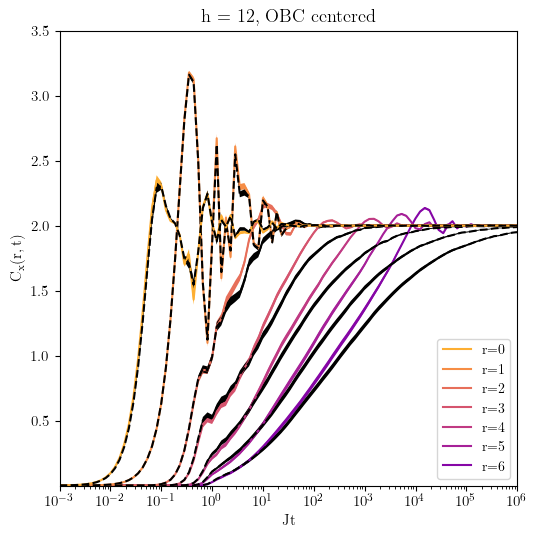

In [39]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red[8][:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_nn[7][:,j],ls="dashed",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, red[8][:,j]-red_sem[8][:,j], red[8][:,j]+red_sem[8][:,j])
    ax.fill_between(T, red_nn[7][:,j]-red_sem_nn[7][:,j], red_nn[7][:,j]+red_sem_nn[7][:,j],fc="black")


handles, labels = ax.get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, OBC centered".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()

# h = 12 OBC non-centered

In [40]:
rvals_nc = np.array([abs(pos-3) for pos in range(0,N)])

In [41]:
rvals_nc

array([3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

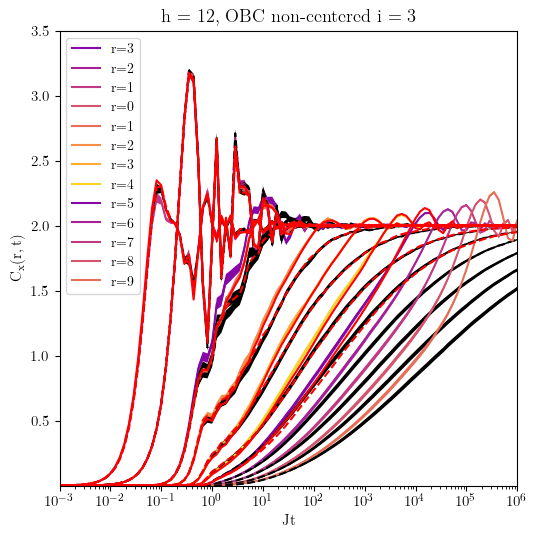

In [42]:
fig = plt.figure(figsize=set_size())
ax = fig.add_subplot(111)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
ax.set_xscale("log")
for j in range(0,N):
    ax.plot(T,res[9][:,j],label="r={}".format(rvals_nc[j]))
    ax.plot(T,res_nn[8][:,j],ls="dashed",c="black")
    #ax.errorbar(T,red[3][:,j],yerr=red_sem[3][:,j],label="r={}".format(rvals[j]),capsize=2)
    #ax.errorbar(T,red_nn[3][:,j],yerr=red_sem_nn[3][:,j],c="black",ls="dashed",capsize=2)

    ax.fill_between(T, res[9][:,j]-res_sem[9][:,j], res[9][:,j]+res_sem[9][:,j])
    ax.fill_between(T, res_nn[8][:,j]-res_sem_nn[8][:,j], res_nn[8][:,j]+res_sem_nn[8][:,j],fc="black")

for j in range(0,N//2+1):
    ax.plot(T,red[8][:,j],c="red")
    ax.plot(T,red_nn[7][:,j],ls="dashed",c="red")


ax.legend()
#handles, labels = ax.get_legend_handles_labels()
#order = np.flip(np.arange(0,N//2+1,1))
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")
ax.set_xlabel(r"Jt")
ax.set_ylabel(r"$\mathrm{C_x(r,t)}$")
ax.set_title(r"h = {}, OBC non-centered i = 3".format(12))
ax.set_xlim(1e-3,1e6)
ax.set_ylim(1e-6,3.5)
#ax.set_yscale("log")
plt.show()